In [ ]:
import pandas as pd #資料整理與分析
import numpy as np #基本計算
import scipy.optimize as solver # type: ignore #規劃求解
import statistics as stat #統計數字，回傳投資組合超額報酬率，標準差與Sharpe ratio 
import matplotlib.pyplot as plt #畫圖用
from functools import reduce # 做矩陣中數值的相加
import statsmodels.api as reg # type: ignore #回歸

# Monthly_TEJ_return = pd.read_excel('櫃買portfolio.xlsx',sheet_name = 'raw data', index_col='年月日')
# Monthly_TEJ_return['MB64_M'] = Monthly_TEJ_return['MB64_Y']/5.19999999
# Monthly_TEJ_return.tail(4)

In [48]:
# Monthly_excess_return = Monthly_TEJ_return.iloc[0:60,0:-2] #只取個股+Y9999[列,行]
# for column in Monthly_excess_return:
#     Monthly_excess_return[column] = (Monthly_excess_return[column] - Monthly_TEJ_return['MB64_M'])/100 #純數值#
# Monthly_excess_return

In [49]:
# Monthly_excess_return = Monthly_excess_return.iloc[:]
# Monthly_cov_matrix = Monthly_excess_return.cov()
# Monthly_cov_matrix

In [50]:

# 資產名稱
assets = ['3211 順達', '6925 意藍', '3363 上詮', '6223 旺矽', '2072 世紀風電']

# 協方差矩陣資料
cov_matrix_data = [
    [0.1723, 0.0065, 0.0282, 0.0289, 0.0209],
    [0.0065, 0.5480, 0.0128, 0.0131, 0.0095],
    [0.0282, 0.0128, 0.4455, 0.0570, 0.0414],
    [0.0289, 0.0131, 0.0570, 0.2350, 0.0424],
    [0.0209, 0.0095, 0.0414, 0.0424, 0.2417],
    
]

# 建立 DataFrame
cov_matrix = pd.DataFrame(data=cov_matrix_data, index=assets, columns=assets)

# # 顯示協方差矩陣
print(cov_matrix)


           3211 順達  6925 意藍  3363 上詮  6223 旺矽  2072 世紀風電
3211 順達     0.1723   0.0065   0.0282   0.0289     0.0209
6925 意藍     0.0065   0.5480   0.0128   0.0131     0.0095
3363 上詮     0.0282   0.0128   0.4455   0.0570     0.0414
6223 旺矽     0.0289   0.0131   0.0570   0.2350     0.0424
2072 世紀風電   0.0209   0.0095   0.0414   0.0424     0.2417


In [51]:
Annual_cov_matrix = cov_matrix
Annual_cov_matrix

,3211 順達,6925 意藍,3363 上詮,6223 旺矽,2072 世紀風電
3211 順達,0.1723,0.0065,0.0282,0.0289,0.0209
6925 意藍,0.0065,0.5480,0.0128,0.0131,0.0095
3363 上詮,0.0282,0.0128,0.4455,0.0570,0.0414
6223 旺矽,0.0289,0.0131,0.0570,0.2350,0.0424
2072 世紀風電,0.0209,0.0095,0.0414,0.0424,0.2417


In [ ]:
Forecasted_return = pd.read_excel("櫃買portfolio.xlsx",sheet_name = 'raw', index_col='SotckID')
Forecasted_return.head(10)

,forecasted_excess_return
SotckID,
3211 順達,0.2211
6925 意藍,0.1877
3363 上詮,0.3345
6223 旺矽,0.2265
2072 世紀風電,0.1877


In [53]:
Ret=Forecasted_return.forecasted_excess_return

In [54]:
numAssets=len(Ret) #指定元素個數
weights = np.array([1.0 / numAssets for x in range(numAssets)]) #np.array用來處理陣列的數值
weights


array([0.2, 0.2, 0.2, 0.2, 0.2])

In [55]:
r = sum(weights*Ret)
s = np.sqrt(reduce(np.dot, [weights, Annual_cov_matrix, weights.T])) 

In [56]:
def statistics(weights): 
    weights=np.array(weights)
    portfolio_return=sum(weights*Ret)
    portfolio_risk=np.sqrt(reduce(np.dot, [weights, Annual_cov_matrix, weights.T])) 
    return np.array([portfolio_return, portfolio_risk, portfolio_return/portfolio_risk])
# def自己定義函數
def max_sharpe(weights):
    return -statistics(weights)[2]
x0 = np.array([1.0 / numAssets for x in range(numAssets)])
constraints = {'type': 'eq', 'fun': lambda x: sum(x) - 1}
bounds = tuple((-1, 1) for x in range(numAssets))
opts = solver.minimize(max_sharpe, x0=x0,constraints=constraints, bounds=bounds)
statistics(opts['x']).round(4)

array([0.2349, 0.2821, 0.8325])

In [57]:
opts['x'].round(4)

array([0.3467, 0.1   , 0.1886, 0.2036, 0.1611])

In [58]:
def min_variance(weights):
    return statistics(weights)[1] ** 2
x0 = np.array([1.0 / numAssets for x in range(numAssets)])
constraints = {'type': 'eq', 'fun': lambda x: sum(x) - 1}
bounds = tuple((-1, 1) for x in range(numAssets))
optv = solver.minimize(min_variance, x0=x0,constraints=constraints, bounds=bounds)
statistics(optv['x']).round(4) 

array([0.2215, 0.274 , 0.8085])

In [59]:
optv['x'].round(4)

array([0.3542, 0.1218, 0.0954, 0.2061, 0.2225])

In [60]:
def Given_Return_MVP(weights):
    return np.sqrt(reduce(np.dot, [weights, Annual_cov_matrix, weights.T]))

x0 = np.array([1.0 / numAssets for x in range(numAssets)])
bounds = tuple((-1, 1) for x in range(numAssets))

given_r = np.arange(0.1,0.35S,0.001)
risk = []

for i in given_r:
    constraints = [{'type': 'eq', 'fun': lambda x: sum(x) - 1},
                   {'type': 'eq', 'fun': lambda x: sum(x * Ret) - i}]
    outcome = solver.minimize(Given_Return_MVP, x0=x0,constraints=constraints, bounds=bounds)
    risk.append(outcome.fun)
    np.set_printoptions(suppress=True, precision=4) #讓python輸出數值時不要跑出科學記號
    print(statistics(outcome['x']).round(4))
    print(outcome['x'].round(4))

[0.1    0.6715 0.1489]
[ 0.4215  0.3207 -0.7531  0.2264  0.7846]
[0.101  0.6669 0.1515]
[ 0.4209  0.319  -0.7462  0.2262  0.78  ]
[0.102  0.6623 0.154 ]
[ 0.4204  0.3173 -0.7392  0.2261  0.7754]
[0.103  0.6577 0.1566]
[ 0.4198  0.3157 -0.7322  0.2259  0.7708]
[0.104  0.6531 0.1592]
[ 0.4192  0.3149 -0.7251  0.2253  0.7657]
[0.105  0.6485 0.1619]
[ 0.4186  0.3133 -0.7181  0.2252  0.761 ]
[0.106  0.644  0.1646]
[ 0.4181  0.3116 -0.7111  0.225   0.7564]
[0.107  0.6394 0.1673]
[ 0.4175  0.31   -0.7041  0.2248  0.7518]
[0.108  0.6349 0.1701]
[ 0.4169  0.3083 -0.6972  0.2247  0.7472]
[0.109  0.6303 0.1729]
[ 0.4164  0.3067 -0.6902  0.2245  0.7426]
[0.11   0.6258 0.1758]
[ 0.4158  0.305  -0.6832  0.2243  0.738 ]
[0.111  0.6212 0.1787]
[ 0.4152  0.3034 -0.6762  0.2242  0.7334]
[0.112  0.6167 0.1816]
[ 0.4147  0.3017 -0.6692  0.224   0.7288]
[0.113  0.6122 0.1846]
[ 0.4141  0.3001 -0.6622  0.2238  0.7242]
[0.114  0.6077 0.1876]
[ 0.4136  0.2985 -0.6553  0.2237  0.7196]
[0.115  0.6032 0.1907]
[ 

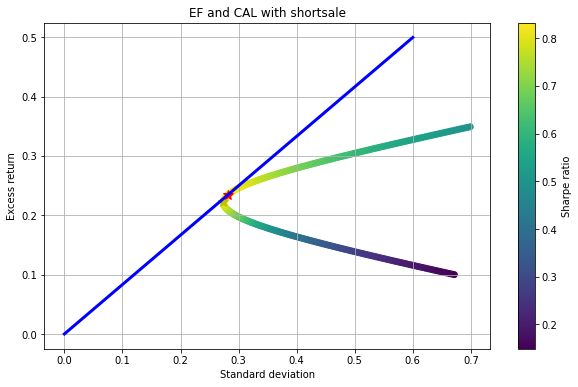

In [61]:
plt.figure(figsize=(10,6)) 
plt.scatter(risk,given_r,c=given_r/risk, marker='o')
plt.plot(statistics(opts['x'])[1], statistics(opts['x'])[0],'r*',markersize=10) #tangent portfolio
# opts['x']的第1個數:tangent' risk,opts['x']的第0個數: tangent' return
plt.plot(statistics(optv['x'])[1], statistics(optv['x'])[0],'y*',markersize=10) # Global minimum variance portfolio
# optv['x']的第1個數:Gmvp' risk,optv['x']的第0個數: Gmvps' return

# plot capital allocation line
x = np.linspace(0, 0.6, 1000)
plt.plot(x, 0.8325*x,'b',linewidth=3)  

plt.grid(True)
plt.xlabel('Standard deviation')
plt.ylabel('Excess return')
plt.title('EF and CAL with shortsale')
plt.colorbar(label='Sharpe ratio')
plt.savefig('Markowitz with shortsale')